In [2]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt
from XBO._utils import TensorManager
tm = TensorManager()
warnings.filterwarnings('ignore')

## 1. Problem definition
Let's get started with the toy example of two-dimensional Branin function.<br>
More details can be found [here](https://www.sfu.ca/~ssurjano/branin.html)<br>
- bounds: -2 from 3
- variable type: continuous
- ground truth X: [-1.02543108, -1.02543108]
- ground truth Y: 10.6043
- optimisation: maximisation

In [3]:
def BraninFunction(x):
    x = torch.atleast_2d(x)
    return ((x.sin() + (3*x).cos()/2).square() / ((x/2).square()+0.3)).prod(axis=1)

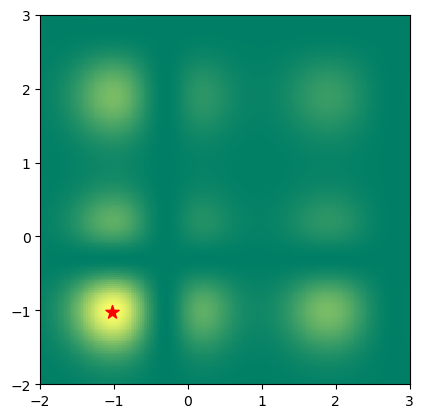

In [4]:
lower_limit = -2
upper_limit = 3
colour_map = 'summer'
resolution = 200
ground_truth = torch.tensor([-1.02543108, -1.02543108])

def get_plotting_domain():
    x = torch.linspace(lower_limit, upper_limit, resolution)
    y = torch.linspace(lower_limit, upper_limit, resolution)
    x_grid, y_grid = torch.meshgrid(x, y)
    X_grid = torch.dstack([x_grid, y_grid]).reshape(resolution**2, 2)
    return tm.standardise_tensor(X_grid)

def plot_function(data, ax):
    data = tm.numpy(data).reshape(resolution, resolution)
    image = ax.imshow(
        data,
        cmap=plt.get_cmap(colour_map),
        vmin=data.min(),
        vmax=data.max(),
        extent=[lower_limit, upper_limit, lower_limit, upper_limit],
        interpolation='nearest',
        origin='lower',
    )
    ax.scatter(ground_truth[1], ground_truth[0], s=100, marker="*", color="red")

def plot_white(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=10, color="white")

def plot_black(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=30, marker="+", color="black")
    
fig, ax = plt.subplots()
Xgrid = get_plotting_domain()
Ygrid = BraninFunction(Xgrid)
plot_function(Ygrid, ax)
plt.show()

We assume we have a prior knowledge about this function.<br>
And we try to guide BO to rectify their recommendatation with help of explanation features.<br>
<br>
As we can see, the global maximum is at around [-1, -1].<br>
We can also observe there are 9 peaks for this function.<br>
We can expect BO can be stuck in one of these local maxima.<br>
<br>
Let's try to shepherd BO go to [-1, -1].

## 2. Define domain
Next, we define the domain of interest.
We set domain as uniform distribution bounded -2 from 3.

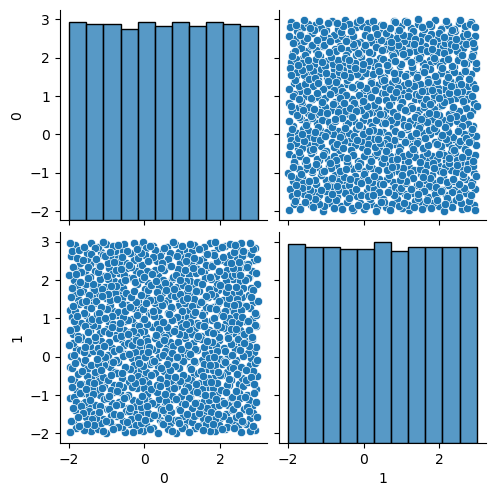

In [5]:
import seaborn as sns
import pandas as pd

# set bounds
n_dims = 2                          # number of dimensions
mins = lower_limit * torch.ones(n_dims)
maxs = upper_limit * torch.ones(n_dims)
bounds = torch.vstack([mins, maxs]) # bounds

# set domain
from XBO._prior import Uniform    # Import prior from SOBER libraries
domain = Uniform(bounds)
true_function = BraninFunction

# visualise domain
samples = domain.sample(1000)
sns.pairplot(pd.DataFrame(tm.numpy(samples)))
plt.show()

## 3. Preferential learning
Next, we try to learn the prior knowledge of human user.<br>
For simplicity, this pretraining process is automatically generated with 80% accuracy.

In [6]:
from XBO._xbo import XBOwithHuman, StateManager
n_init_pref = 100      # number of initial random samples for preferential learning
n_init_obj = 20       # number of initial random samples for objective function

xbo = XBOwithHuman(domain, true_function)
dataset_obj, dataset_duel = xbo.initial_sampling(n_init_obj, n_init_pref, query_to_human=False)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## 4. Run CoExBO
Now, we will collaborate with BO for faster convergence.<br>
<br>
### Rules
- You will get the pair of points (X0, X1).
- X0 is generated by the preference-based model.
- X1 is generated by the standard UCB. Namely, normal BO.
- You need to answer which you think larger.
- Type "0" if you think f_true(X0) > f_true(X1).
- Otherwise type "1".
- If you are unsure, type "2". Then, X1 is selected but it makes preference model remain unsure at the given pairwise candidate location. 
- We will iterate this back and forth at $n_{iterations}$ times

### Role of explanations
- The explanation is for demystifying the GP acquisition process, rather than giving "oracle" explanation guiding to the true global optimum.
- As such, YOU need to know the blackbox function better than GP. You should keep in mind the explanation is just advice, and you need to select based on your internal belief.
- In this example, particularly we know the global optimum location ambiguously (at around [-1,-1]).
- Note that the early-stage GP is unreliable. All explanation is based on GP, so the early-stage explanation is not a good adviser. It can be useful to rectify your over-trust over GP. 
- Conversely, the later round GP is reliable. You can use the explanation for fine-tune your understanding.

### Explanation features
- You can ask more information by answering "y" when system asked if you need more explanation. Otherwise type"n" so that you can skip the explanation.
- The first feature is the simple GP prediction. You can check how GP predictive mean, variance, and UCB are different for each candidate. In early stage, mean is just unreliable. Uncertainty will give insights how likely you can get the information.
- The second feature is the Shapley value. This gives the importance of input dimension to the prediction at the given candidate. This example, Branin function, is a uncorrelated dimensions so the two dimensions should be equal contribution. If the Shapley values give biased feature importance, GP is likely to be misspecified (particularly in the early stages.).
- The third feature is the visualisation of each candidate. It will automatically visualise the 2 dimensional plot of GP predictive mean and variance based on top 2 largest Shapley values. You can check the geographical relationship between the candidates and the best observed point.
- The fourth feature is the visualisation of preference-based GP predictive mean and variance. This is the mixture of human preference and surroagte GP model so it is not the pure preference-based plot.
- The last feature is the feeback of your selection. The post-hoc analysis on the probability of correct answer will be returned.

In [9]:
n_iterations = 5      # number of iterations
seed = 0              # random seed for reproduce the results

# initial setting
torch.manual_seed(seed)
state = StateManager(n_dims=n_dims)

0) parameters: beta 5.657e-01 gamma 0.000e+00 sigma 1.000e-01
training models...
generating candidates...
X1 (normal UCB): tensor([-0.8418, -1.1947])
X0 (preference): tensor([-0.9376, -1.2529])
Do you need more explanation on the two candidates?
Type y if yes, otherwise type n as noy


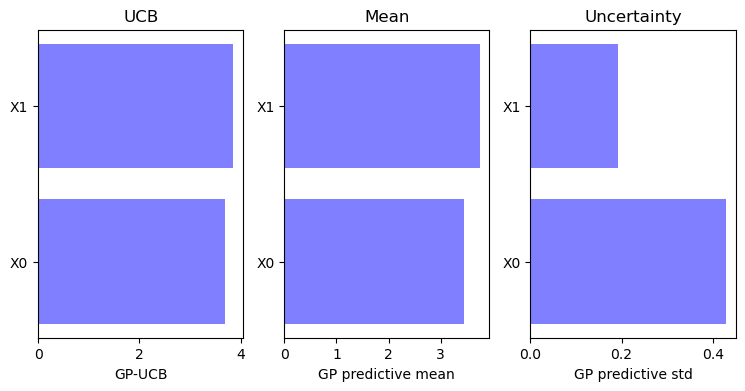

Do you want to know the attribution to each feature?
Type y if yes, otherwise type n as noy


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1883.11it/s]


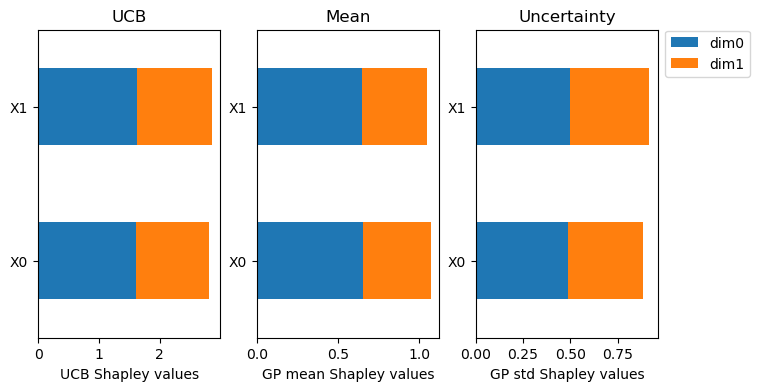

Do you want to visualise the GP on the plane where two candidates are placed?
Type y if yes, otherwise type n as noy
Do you want to specify the dimension by yourself (y)? Otherwise, we estimate based on Shapley value (n)
Type y if yes, otherwise type n as non


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 2052.01it/s]


best observed, white dot o:tensor([-0.7644, -1.2039])
X0 (preference), black star *:tensor([-0.9376, -1.2529])
X1 (normal UCB), green cross +:tensor([-0.8418, -1.1947])
observed points, yellow cross x


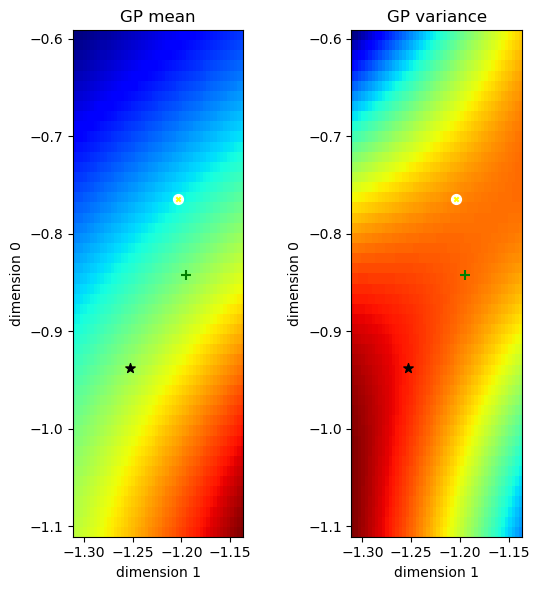

Do you want to visualise the learnt preference model on the plane where two candidates are placed?
Type y if yes, otherwise type n as noy
Do you want to specify the dimension by yourself (y)? Otherwise, we estimate based on Shapley value (n)
Type y if yes, otherwise type n as non


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1892.45it/s]


[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
best observed, white dot o:tensor([-0.7644, -1.2039])
X0 (preference), black star *:tensor([-0.9376, -1.2529])
X1 (normal UCB), green cross +:tensor([-0.8418, -1.1947])
observed points, yellow cross x


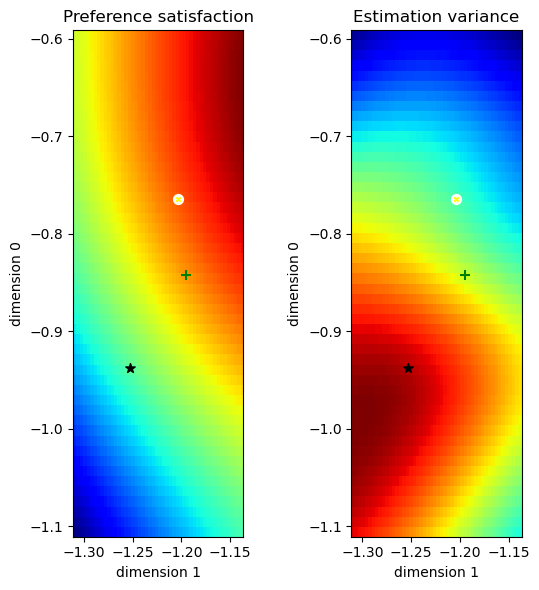

Type 0 or 1 which you think larger. Type 2 if unsure.0
You chose X0
Probability of correct selection: 7.42e-02 ± 2.63e-01
Estimated total correct selection rate of sure samples: nan ± nan
Is your selection correct? Yes if 1: 1
Is your selection sure? Yes if 1: 1
21) Best value: 8.38220e+00
1) parameters: beta 8.000e-01 gamma 1.000e-02 sigma 5.000e-02
training models...
generating candidates...
X1 (normal UCB): tensor([-1.0137, -1.2857])
X0 (preference): tensor([-1.0595, -1.2136])
Do you need more explanation on the two candidates?
Type y if yes, otherwise type n as noy


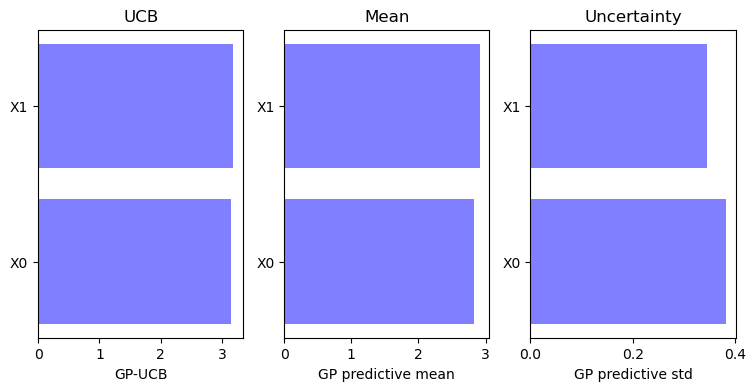

Do you want to know the attribution to each feature?
Type y if yes, otherwise type n as noy


  0%|                                                     | 0/3 [00:00<?, ?it/s]

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  4.39it/s]


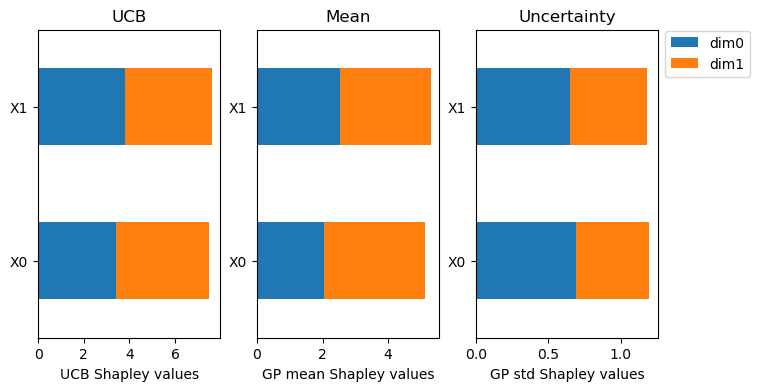

Do you want to visualise the GP on the plane where two candidates are placed?
Type y if yes, otherwise type n as noy
Do you want to specify the dimension by yourself (y)? Otherwise, we estimate based on Shapley value (n)
Type y if yes, otherwise type n as non


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 2078.79it/s]


best observed, white dot o:tensor([-0.9376, -1.2529])
X0 (preference), black star *:tensor([-1.0595, -1.2136])
X1 (normal UCB), green cross +:tensor([-1.0137, -1.2857])
observed points, yellow cross x


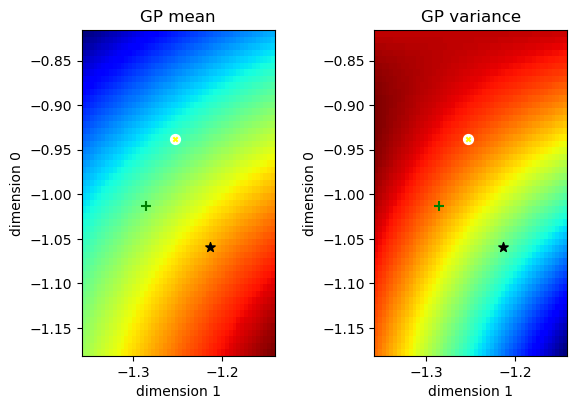

Do you want to visualise the learnt preference model on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Type 0 or 1 which you think larger. Type 2 if unsure.1
You chose X1
Probability of correct selection: 9.56e-01 ± 1.86e-01
Estimated total correct selection rate of sure samples: 1.00e+00 ± 6.52e-09
Is your selection correct? Yes if 1: 0
Is your selection sure? Yes if 1: 1
22) Best value: 8.38220e+00
2) parameters: beta 9.798e-01 gamma 4.000e-02 sigma 3.333e-02
training models...
generating candidates...
X1 (normal UCB): tensor([-0.9768, -1.1897])
X0 (preference): tensor([-1.0009, -1.1222])
Do you need more explanation on the two candidates?
Type y if yes, otherwise type n as noy


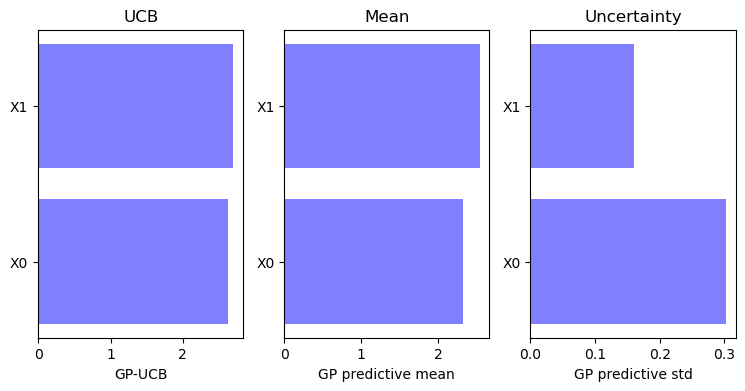

Do you want to know the attribution to each feature?
Type y if yes, otherwise type n as non
Do you want to visualise the GP on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Do you want to visualise the learnt preference model on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Type 0 or 1 which you think larger. Type 2 if unsure.0
You chose X0
Probability of correct selection: 5.08e-02 ± 2.20e-01
Estimated total correct selection rate of sure samples: 8.73e-01 ± 2.16e-01
Is your selection correct? Yes if 1: 1
Is your selection sure? Yes if 1: 1
23) Best value: 1.01843e+01
3) parameters: beta 1.131e+00 gamma 9.000e-02 sigma 2.500e-02
training models...
generating candidates...
X1 (normal UCB): tensor([-1.0372, -1.0295])
X0 (preference): tensor([-1.0069, -0.9685])
Do you need more explanation on the two candidates?
Type y if yes, otherwise type n as noy


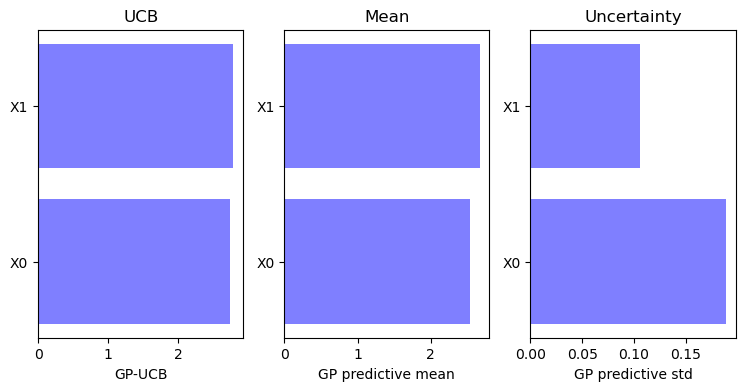

Do you want to know the attribution to each feature?
Type y if yes, otherwise type n as noy


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1896.44it/s]


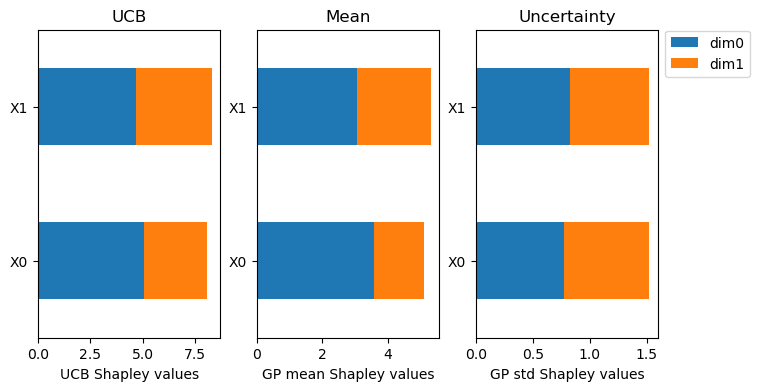

Do you want to visualise the GP on the plane where two candidates are placed?
Type y if yes, otherwise type n as noy
Do you want to specify the dimension by yourself (y)? Otherwise, we estimate based on Shapley value (n)
Type y if yes, otherwise type n as non


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 2112.64it/s]


best observed, white dot o:tensor([-1.0009, -1.1222])
X0 (preference), black star *:tensor([-1.0069, -0.9685])
X1 (normal UCB), green cross +:tensor([-1.0372, -1.0295])
observed points, yellow cross x


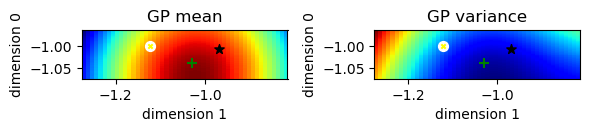

Do you want to visualise the learnt preference model on the plane where two candidates are placed?
Type y if yes, otherwise type n as no0
Type 0 or 1 which you think larger. Type 2 if unsure.0
You chose X0
Probability of correct selection: 3.54e-02 ± 1.85e-01
Estimated total correct selection rate of sure samples: 6.66e-01 ± 3.82e-03
Is your selection correct? Yes if 1: 0
Is your selection sure? Yes if 1: 1
24) Best value: 1.04427e+01
4) parameters: beta 1.265e+00 gamma 1.600e-01 sigma 2.000e-02
training models...
generating candidates...
X1 (normal UCB): tensor([-1.0727, -1.0189])
X0 (preference): tensor([-1.1120, -1.0066])
Do you need more explanation on the two candidates?
Type y if yes, otherwise type n as noy


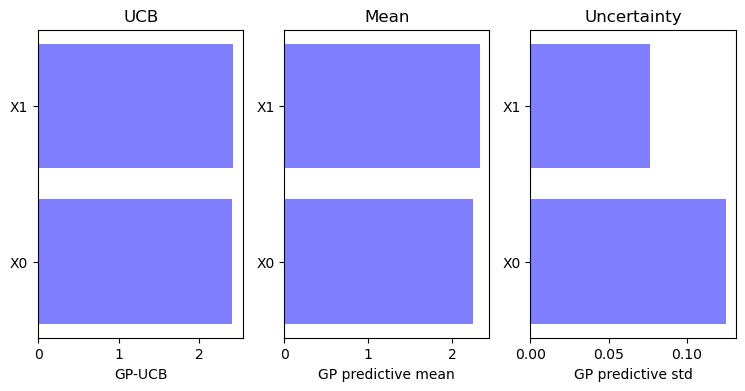

Do you want to know the attribution to each feature?
Type y if yes, otherwise type n as non
Do you want to visualise the GP on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Do you want to visualise the learnt preference model on the plane where two candidates are placed?
Type y if yes, otherwise type n as non
Type 0 or 1 which you think larger. Type 2 if unsure.1
You chose X1
Probability of correct selection: 9.48e-01 ± 2.21e-01
Estimated total correct selection rate of sure samples: 5.30e-01 ± 8.04e-02
Is your selection correct? Yes if 1: 1
Is your selection sure? Yes if 1: 1
25) Best value: 1.05057e+01


In [10]:
results = []
for t in range(n_iterations):
    beta, gamma, radius = state(t)
    dataset_obj, dataset_duel, result = xbo(
        dataset_obj, dataset_duel, beta, gamma,
    )
    print(f"{len(dataset_obj[0])}) Best value: {dataset_obj[1].max().item():.5e}")
    results.append(result)

results = torch.tensor(results)

# Results
[overhead(s), best observation, Euclidean distance, correct answer, sure answer]

In [11]:
results

tensor([[34.1419,  6.7332,  0.3153,  1.0000,  1.0000],
        [32.6994,  8.3822,  0.1540,  0.0000,  1.0000],
        [19.8512,  8.3822,  0.1213,  1.0000,  1.0000],
        [34.4204, 10.1843,  0.0384,  0.0000,  1.0000],
        [15.3078, 10.4427,  0.1054,  1.0000,  1.0000]])